*This notebook was done as the final project of the course Computational Neuroscience 202 of École Normale Supérieure COGMASTER*

*Author: Nicolás Marcelo Bruno*

In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import exp, sqrt, cos, sin
from scipy.special import erf  # error function
from scipy.optimize import fmin  # equivalent to fminsearch of matlab
from scipy.stats import circstd

In [3]:
plt.style.use("ggplot")
fig_width = 8  # width in inches
fig_height = 6  # height in inches
fig_size = [fig_width, fig_height]
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["figure.autolayout"] = True

sns.set(style="white", context="notebook", palette="Set1", font_scale=1.5)

# Optimal representation of sensory information by neural populations

Jazayeri2006 has developed a model that is simple and neurally plausible that computes the full likelihood function. This model pools the activity of sensory neurons in is a simple additive feed-forward architecture.  This means, that the information flows only in one direction without any kind of loops. This model was develop for an abstract population of neurons and then applied to MT (V5) neurons of the visual cortex under a Random Dot Motion task.

The current project has the objective of replicating the model and results obtained by Jazayeri2006. 

## Table of contents
1. [General](#general)

    1.1. [General Parameters](#general_parameters)

    1.2. [General Functions](#general_functions)

            1.2.1 Tuning Curve

            1.2.2 Correlation function

2. [Motion Detection Task](#detection_task)
    
    2.1.[Detection Task Functions](#detection_functions)

            2.1.1.Log Likelihood Function

            2.1.2.Mean and Variance

            2.1.3.Noise distribution Mean and Variance

            2.1.4.ROC curve: Hit Rate, False Alarms and d'
    2.2 [Figure 3.A](#fig_3a)
3. [Motion Identification Task](#identification)
    
    3.1 [Identification task Functions](#identification_functions)
    
    3.3 [Figure 3.B](#fig_3b)

4. [Motion Discrimination Task](#discrimination_task)

    4.1 [Discrimination Task Parameters](#discriminatio_parameter)
    
    4.2 [Discrimination Task Functions](#discrimination_task)
            
            4.2.1 Log Likelihood Ratio
            
            4.2.2 Meand And Variance 
    4.3 [Figure 3.C](#fig_3c)
    
5. [Multiple Discrimination task](#multiple_discrimination)  

    3.4 [Figure 3.C](#fig_3d)
    
6. [Final Figure 3](#fig3)
    
7. [References](#references)

## General <a name="general"></a>

### General Parameters <a name="general_parameters"></a>
- $N = 720$ ==> number of neurons  
- $\kappa = 3$  ==> equivalent to a bandwidth of $90°$
- $R_{min} = 10 imp/s$ ==> Minimum number of impulses use as threshold
- $R_{max} = 60 imp/s$ ==> Maximum response
- $\rho_{max} = 0.2$ ==> maximum correlation between 2 neurons, two neurons have the same preference
- $\delta = 0.1$ ==> concentration parameter, profile of pairwise correlation.
- $t = 0.11$ seconds ==> this number is not reported, it is just a good guess.
- $\theta_i = random(0°-360°) $ ==> preferred direction angle of the neuron
- $\theta$ ==> Stimulus presented
- $C = [0., 0.03, 0.06, 0.13, 0.25]$ ==> List of motion coherence drawn from the paper from figure 3.A

In [4]:
N = 720
kappa = 3
R_min = 10
R_max = 60
rho_max = 0.2
delta = 0.1
t = 0.11  # seconds
theta_i = np.radians(
    np.random.randint(0, 360, 720)
)  # draw random degrees and convert them to radians
C = [0.0, 0.03, 0.06, 0.13, 0.25]

thetas = np.linspace(0, 359, 100)  # all possible theta values

### General Functions <a name="general_functions"></a>

#### Tuning curve: <a name="tuning_curve"></a>

$f_i(\theta) = exp \{\kappa[ \cos (\theta - \theta_i) -1 ] \}  $

In [5]:
def tuning(N, kappa, theta, theta_i):
    f = np.zeros(N)
    for i in range(N):
        f[i] = exp(kappa * (cos(np.radians(theta) - theta_i[i]) - 1))
    return f

#### Correlation between two neurons: <a name="corr_matrix"></a>

$\rho_{ij} = \rho_{max} exp \{ \delta [ \cos (\theta_i - \theta_j) -1 ] \}  $

In [6]:
def rho_ij(N, rho_max, delta, theta_i):
    corr_matrix = np.zeros([N, N])
    for i in range(N):
        for j in range(N):
            corr_matrix[i, j] = rho_max * exp(
                delta * (cos(theta_i[i] - theta_i[j]) - 1)
            )
    return corr_matrix

In [24]:
def spikes(N, C, t, R_max, kappa, theta, theta_i):
    f = tuning(N, kappa, theta, theta_i)
    n = np.array([np.random.poisson((f[i] * C * R_max) / t) for i in range(N)])
    return n

## Detection Task <a name="detection_task"></a>

### Functions Detection task <a name="detection_functions"></a>

#### Log Likelihood <a name="detection_log"></a>

$\log L(\theta) = \sum_{i = 1}^N \log L_i (\theta) = \sum_{i = 1}^N n_i \log fi(\theta)$

For Random dot motion:

$\log L(\theta) = k \sum_{i = 1}^N n_i \cos \left(\theta - \theta_i \right)$


In [22]:
def log_L(N, kappa, theta, theta_i, C, R_max):
    n = spikes(N, C, t, R_max, kappa, theta, theta_i)
    return kappa * sum([n[i] * cos(np.radians(theta) - theta_i[i]) for i in range(N)])

#### Mean and Variance <a name="detection_mean&var"></a>

$\mu_L = \kappa (R_{min} + CR_{max}) t \sum_{i = 1}^N f_i(\theta) \cos (\theta - \theta_i) $

$\sigma_L^2 = \kappa^2 (R_{min} + CR_{max})  \sum_{i = 1}^N  \sum_{j = 1}^N \rho_{ij} \sqrt{f_i(\theta)f_j(\theta)}\cos(\theta - \theta_i) \cos(\theta - \theta_j)$

In [9]:
def mean_L(N, kappa, C, R_max, R_min, t, theta, theta_i):
    f = tuning(N, kappa, theta, theta_i)
    return (
        kappa
        * (R_min + (C * R_max))
        * t
        * sum([f[i] * cos(np.radians(theta) - theta_i[i]) for i in range(N)])
    )


def var_L(N, kappa, C, R_max, R_min, t, theta, theta_i, rho_max, delta):
    rho = rho_ij(N, rho_max, delta, theta_i)
    f = tuning(N, kappa, theta, theta_i)
    return (
        (kappa ** 2)
        * (R_min + (C * R_max))
        * t
        * sum(
            [
                sum(
                    [
                        rho[i, j]
                        * sqrt(f[i] * f[j])
                        * cos(np.radians(theta) - theta_i[i])
                        * cos(np.radians(theta) - theta_i[j])
                        for j in range(N)
                    ]
                )
                for i in range(N)
            ]
        )
    )

#### Mean and Variance for noise distribution <a name="detection_noise_mean&var"></a>

$mu_{noise} = \kappa R_{min} t \sum_{i = 1}^N f_i(\theta) \cos (\theta - \theta_i)$

$\sigma_{moise} = \kappa^2 R_{min}  t\sum_{i = 1}^N  \sum_{j = 1}^N \rho_{ij} \sqrt{f_i(\theta)f_j(\theta)}\cos(\theta - \theta_i) \cos(\theta - \theta_j)$

In [10]:
def mean_noise(N, kappa, R_min, t, theta, theta_i):
    f = tuning(N, kappa, theta, theta_i)
    return (
        kappa
        * R_min
        * t
        * sum([f[i] * cos(np.radians(theta) - theta_i[i]) for i in range(N)])
    )


def var_noise(N, kappa, R_min, t, theta, theta_i, rho_max, delta):
    rho = rho_ij(N, rho_max, delta, theta_i)
    f = tuning(N, kappa, theta, theta_i)
    return (
        (kappa ** 2)
        * R_min
        * t
        * sum(
            [
                sum(
                    [
                        rho[i, j]
                        * sqrt(f[i] * f[j])
                        * cos(np.radians(theta) - theta_i[i])
                        * cos(np.radians(theta) - theta_i[j])
                        for j in range(N)
                    ]
                )
                for i in range(N)
            ]
        )
    )

#### ROC Curve funcction: Hit Rate, False Alarm Rate and d' <a name="roc"></a>

$FA = \int_{criterion}^{+\infty} P(x; \mu_2, \sigma_2) dx$

$H   = \int_{criterion}^{\infty} P(x; \mu_L, \sigma_L) dx$

Integrating with the Error Function:

$FA = 0.5 \cdot (1-erf(criterion-\mu_2)\sqrt{2\cdot \sigma_2^2})$

$H = 0.5 \cdot (1-erf(criterion-\mu_L)\sqrt{2 \cdot \sigma_L^2})$

$d'$ for sensitivy meassure:

$d' = \frac{\mu_{L} - \mu_{noise}}{\sqrt{\frac{1}{2}}{(\sigma_{L}^2+ \sigma_{noise}^2)}}$


In [11]:
def roc(th_inf, th_sup, mu_L, sigma_L, mu_noise, sigma_noise):
    h_rate = np.zeros(th_sup - th_inf)
    fa_rate = np.zeros(th_sup - th_inf)
    for i, v in enumerate(range(th_inf, th_sup)):
        h_rate[i] = (1 / 2) * (1 - erf((v - mu_L) / sqrt(2 * sigma_L)))
        fa_rate[i] = (1 / 2) * (1 - erf((v - mu_noise) / sqrt(2 * sigma_noise)))
        dprime = (mu_L - mu_noise) / sqrt(0.5 * (sigma_L + sigma_noise))

    return h_rate, fa_rate, dprime

### Exploratory analysis <a name="detection_exploratory"></a>

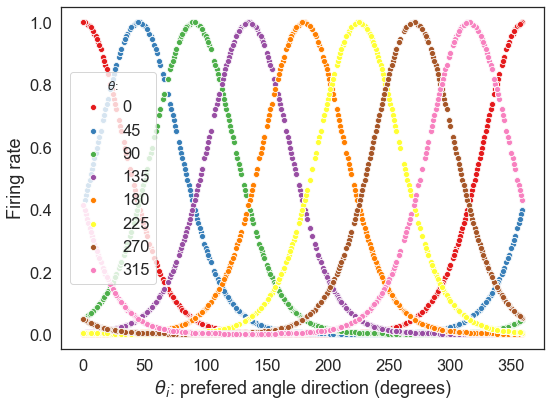

In [12]:
thetas_ = [0, 45, 90, 135, 180, 225, 270, 315]
for theta in thetas_:
    sns.scatterplot(np.rad2deg(theta_i), tuning(N, kappa, theta, theta_i))
plt.xlabel(r"$\theta_i$: prefered angle direction (degrees)")
plt.ylabel("Firing rate")
plt.legend(thetas_, title=r"$\theta$:", loc="best")
plt.savefig("figs/tuning_curve.png", dpi=600)
plt.show()

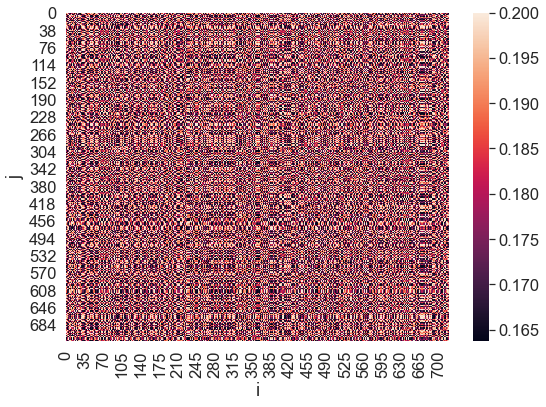

In [13]:
# correlation matrix
sns.heatmap(rho_ij(N, rho_max, delta, theta_i))
plt.xlabel("i")
plt.ylabel("j")
plt.show()

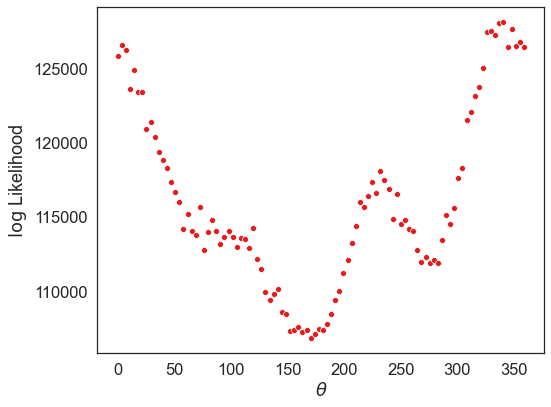

In [25]:
logs = []
for theta in thetas:
    logs.append(log_L(N, kappa, theta, theta_i, 0.5, R_max))

sns.scatterplot(thetas, logs)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\log$ Likelihood")
plt.savefig("figs/log_function.png", dpi=600)
plt.show()

### Figure 3 A <a name="fig_3a"></a>
The receiver operating characteristic (ROC) for a motion-detection task. The detectability (d¢) of the stimulus and the area under the ROC curve (that is, percent correct) increase with motion signal strength (coherence). High (low) criterion values correspond to the lower-left (upper-right) part of each curve where both the hit and false alarm rates are low (high). 

Usign $\theta = 45°$

The ROC decision criteria was not repored so I obtained by the range between $ \mu_{noise} - 3\sigma_{noise}$ and $\mu_L + 3 \sigma_{L}$

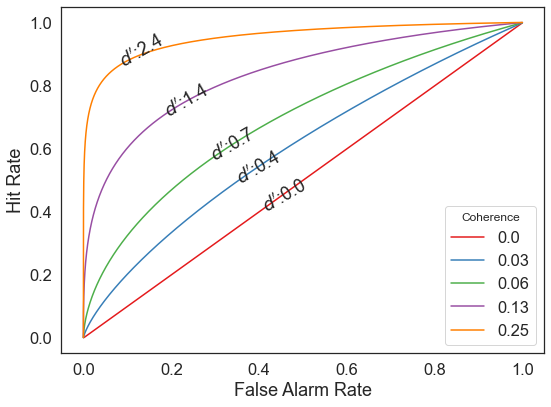

In [15]:
theta = 45

for c in C:
    mu_L = mean_L(N, kappa, c, R_max, R_min, t, theta, theta_i)
    sigma_L = var_L(N, kappa, c, R_max, R_min, t, theta, theta_i, rho_max, delta)
    mu_noise = mean_noise(N, kappa, R_min, t, theta, theta_i)
    sigma_noise = var_noise(N, kappa, R_min, t, theta, theta_i, rho_max, delta)

    HR, FA, dprime = roc(
        th_inf=int(mu_noise - 3 * sqrt(sigma_noise)),
        th_sup=int(mu_L + 3 * sqrt(sigma_L)),
        mu_L=mu_L,
        sigma_L=sigma_L,
        mu_noise=mu_noise,
        sigma_noise=sigma_noise,
    )

    sns.lineplot(FA, HR)
    if c == 0.0:
        plt.text(
            0.4, 0.4, r"$d'$:" + str(round(dprime, 1)), rotation=30,
        )
    else:
        plt.text(
            FA[np.argmax(HR - FA)],
            HR[np.argmax(HR - FA)],
            r"$d'$:" + str(round(dprime, 1)),
            rotation=30,
        )

plt.xlabel("False Alarm Rate")
plt.ylabel("Hit Rate")
plt.legend(C, title="Coherence", loc="best")
plt.savefig("figs/fig_3_A.png", dpi=600)
plt.show()

## Identification Task <a name="identification"></a>
The functions used here are the same that were used for the Multiple discrimination task

 ### Functions Identification Task <a name="functions identification"></a>
The log likelihood of any direction of motion can be readily computed from
any other two non–degenerate log likelihoods. Imagine that we know two points on the full
likelihood function, say, Lθ1 and Lθ 2. We can write

$L_{\theta_1} = \kappa \sum_{i = 1}^N n_i [\cos(\theta_1)\cos(\theta_i) + \sin(\theta_1)\sin(\theta_i)]$

$L_{\theta_2} = \kappa \sum_{i = 1}^N n_i [\cos(\theta_2)\cos(\theta_i) + \sin(\theta_2)\sin(\theta_i)]$

In Matrix form:

$\left(\begin{array}{cc} L_{\theta1}\\ L_{\theta2} \end{array}\right) = \left(\begin{array}{cc} \cos(\theta_1)&\sin(\theta_1)\\ \cos(\theta_2)&\sin(\theta_2) \end{array}\right) \left(\begin{array}{cc} \sum_{i = 1}^N n_i\cos(\theta_i)\\ \sum_{i = 1}^N n_i\sin(\theta_i) \end{array}\right)  $

the log likelihood of any other direction, say, θ3 can be computed as follows: 
    
$L_{\theta_3} = \kappa \sum_{i = 1}^N n_i\cos(\theta_3 - \theta_i) =
\left(\begin{array}{cc} \cos(\theta_3)&\sin(\theta_3) \end{array}\right) 
\left(\begin{array}{cc} \cos(\theta_1)&\sin(\theta_1)\\ \cos(\theta_2)&\sin(\theta_2) \end{array}\right)^{-1}
\left(\begin{array}{cc} L_{\theta1}\\ L_{\theta2} \end{array}\right)
$

In [16]:
def L_(trials, theta_n, theta_i, N, C, t, R_max, R_min, kappa):
    L_n = np.zeros(trials)
    for trial in range(trials):
        n = spikes(N, C, t, R_max, kappa, theta_n, theta_i)
        theta_n = np.radians(theta_n)
        L_n[trial] = kappa * sum(
            [
                n[i] * (cos(theta_n) * cos(theta_i[i]) + sin(theta_n) * sin(theta_i[i]))
                for i in range(N)
            ]
        )

    return L_n

In [17]:
def L_3(
    C, trials, L_1, L_2, theta_3, theta_1, theta_2, theta_i, N, t, R_max, R_min, kappa
):
    l_3 = np.zeros(trials)
    theta_1 = np.radians(theta_1)
    theta_2 = np.radians(theta_2)
    theta_3 = np.radians(theta_3)
    mat1 = np.array([cos(theta_3), sin(theta_3)])
    mat2 = np.array([[cos(theta_1), sin(theta_1)], [cos(theta_2), sin(theta_2)]])
    for trial in range(trials):
        mat3 = np.array([[L_1[trial]], [L_2[trial]]])
        l_3[trial] = np.dot(mat1, np.linalg.inv(mat2)).dot(mat3)
    return l_3

In [42]:
l_3 = np.zeros(trials)
theta_1 = np.radians(theta_1)
theta_2 = np.radians(theta_2)
theta_3 = np.radians(theta_3)
mat1 = np.array([cos(theta_3), sin(theta_3)])
mat2 = np.array([[cos(theta_1), sin(theta_1)], [cos(theta_2), sin(theta_2)]])
for trial in range(trials):
    mat3 = np.array([[L_1[trial]], [L_2[trial]]])
    l_3[trial] = np.dot(mat1, np.linalg.inv(mat2)).dot(mat3)
l_3

array([65121.72367343, 65606.72024337, 66143.44150625, 66408.51484787,
       66066.1893868 , 66156.11224526, 66482.78349202, 65432.71403777,
       66550.47786375, 66090.39444712, 65796.05678915, 65953.37949197,
       65682.74821365, 66147.6340795 , 66322.68352351, 65602.7418208 ,
       65932.43073705, 65531.35809542, 65460.18143184, 65741.92530937,
       66134.58818578, 65410.07466529, 65779.07232527, 66344.44818423,
       65448.78254785, 65583.92147805, 65612.44630804, 66497.5168537 ,
       65590.24714074, 66405.48332329, 65651.01598074, 66335.14340194,
       65977.63166324, 65722.08165199, 65781.42919886, 65293.70308122,
       66290.66733861, 66432.43868513, 65857.16526761, 66206.06064775,
       65951.23352963, 65946.47438792, 65750.4743671 , 66146.73916175,
       65362.35791664, 66068.23746956, 65943.24953165, 66251.88483998,
       66567.42781616, 65298.06534231, 65996.33059356, 65990.45027695,
       65748.53303309, 66214.73878424, 66157.72618039, 65159.22952198,
      

### Figure 3 B <a name="fig_3b"></a>
The precision of the model’s estimate in a direction-of-motion
identification task as a function of coherence. The ordinate shows the relative
increase of circular standard deviation of the estimate compared to the
highest motion strength ($C =  1$). 

In [28]:
# params
Cs = [0.125, 0.25, 0.5, 1]
trials = 100
trials = 100
theta_1 = 0
theta_2 = 45

In [26]:
def opt_thB(Cs, theta_1, theta_2, trials):

    circ_sd = []
    for c in Cs:
        L_1 = L_(trials, theta_1, theta_i, N, c, t, R_max, R_min, kappa)
        L_2 = L_(trials, theta_2, theta_i, N, c, t, R_max, R_min, kappa)
        Ls = np.zeros(trials)

        for i in range(360):
            theta_3 = np.radians(i)
            l_3 = L_3(
                c,
                trials,
                L_1,
                L_2,
                theta_3,
                theta_1,
                theta_2,
                theta_i,
                N,
                t,
                R_max,
                R_min,
                kappa,
            )

            Ls = np.vstack((Ls, l_3))

        max_direction = np.where(np.max(Ls) == Ls)[0]
        circ_sd.append(circstd(Ls[max_direction]))

    return circ_sd

In [30]:
circ_sd = opt_thB(Cs, theta_1, theta_2, trials)

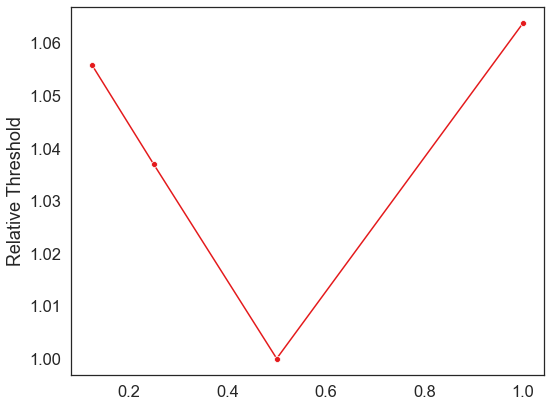

In [31]:
# circ4plot = [v[0] for i, v in enumerate(circ_sd)]

rel_th = circ_sd / min(circ_sd)

sns.lineplot(Cs, rel_th, marker="o")
plt.xlabel("")
plt.ylabel("Relative Threshold")
plt.savefig("figs_fig_3_B.png", dpi=600)
plt.show()

## Discrimination Task <a name="discrimination_task"></a>

### Parameters Discrimination <a name="discrimination_parameters"></a>
- $thetas = [12, 225. 45, 90, 180]$ ==> Drawn from Point in Figure 3 C
- $\theta_1 = 0°$ ==> for all trials 
- $R_{min} = 0$ ==> Here it is not necessary to calculate False Alarms



In [32]:
thetas_2 = [12, 225, 45, 90, 180]
theta_1 = 0
R_min = 0

### Functions 2 alternative Discrimination Task <a name="discrimination_functions"></a>

#### Discrimination task: Log ratio, Mean and Variance

Log likelihood ratio:

$\log LR = 2 \kappa \sin (\Delta \theta) \sum_{i = 1}^N n_i \sin (\theta_i - \theta_m)$

being $\Delta \theta = \frac{\theta_1 - \theta_2}{2}$ and $\theta_m = \frac{\theta_1 + \theta_2}{2}$ where $\theta_1$ was the presented stimulus. 

Mean LR:

$\mu_{LR} = 2 \kappa CR_{max} \sin (\Delta \theta) t \sum_{i = 1}^N f_i(\theta_1) \sin (\theta_i - \theta_m) $

Variance LR:

$\sigma_{LR}^2 = [\kappa \sin (\Delta \theta)]^2 CR_{max}  \sum_{i = 1}^N  \sum_{j = 1}^N \rho_{ij} \sqrt{f_i(\theta_1)f_j(\theta_1)}\sin(\theta_1 - \theta_i) \sin(\theta_1 - \theta_j)$

In [33]:
def log_LR(N, kappa, theta_1, theta_2, theta_i):
    theta_1 = np.radians(theta_1)
    theta_2 = np.radians(theta_2)
    delta_theta = (theta_1 - theta_2) / 2
    theta_m = (theta_1 + theta_2) / 2

    return (
        2
        * kappa
        * sin(delta_theta)
        * sum([sin(theta_i[i] - theta_m) for i in range(N)])
    )


def mean_LR(N, kappa, C, R_max, t, theta_1, theta_2, theta_i):
    f = tuning(N, kappa, theta_1, theta_i)
    theta_1 = np.radians(theta_1)
    theta_2 = np.radians(theta_2)
    delta_theta = (theta_1 - theta_2) / 2
    theta_m = (theta_1 + theta_2) / 2

    return (
        2
        * kappa
        * C
        * R_max
        * sin(delta_theta)
        * t
        * sum([f[i] * sin(np.radians(theta_i[i]) - theta_m) for i in range(N)])
    )


def var_LR(N, kappa, C, R_max, t, theta_1, theta_2, theta_i, rho_max, delta):
    rho = rho_ij(N, rho_max, delta, theta_i)
    f = tuning(N, kappa, theta, theta_i)
    theta_1 = np.radians(theta_1)
    theta_2 = np.radians(theta_2)
    delta_theta = (theta_1 - theta_2) / 2
    theta_m = (theta_1 + theta_2) / 2

    return (
        (2 * kappa * sin(delta_theta)) ** 2
        * C
        * R_max
        * t
        * sum(
            [
                sum(
                    [
                        rho[i, j]
                        * sqrt(f[i] * f[j])
                        * sin(theta_i[i] - theta_m)
                        * sin(theta_i[j] - theta_m)
                        for j in range(N)
                    ]
                )
                for i in range(N)
            ]
        )
    )

#### Performance function
Equation used to assses model performance for two alternative discrimination tasks. 

$P_c = \frac{1}{\sqrt{2\pi\sigma_{LR}^2}} \int_0^\infty \exp \bigg[\frac{-(x - \mu_{LR})^2}{2\sigma_{LR}^2} \bigg] dx$

This function can be solved as was done for the hit rate, as it is the same equation:

$P_c = \frac{1}{2}\bigg(1-erf(criterion-\mu_{LR})\sqrt{2 \cdot \sigma_{LR}^2} \bigg)$

Using 0 as criterion

In [34]:
def P_c(mu_LR, sigma_LR, criterion=0):
    return (0.5) * (1 - erf((criterion - mu_LR) / sqrt(2 * sigma_LR)))

### Figure 3 C <a name="fig_3c"></a>
 Coherence threshold of the model in two-alternative motion discrimination tasks differing in the angular difference between the two discriminanda. The ordinate shows the relative change in coherence threshold as a function of the angular difference between the two alternatives, compared to the easiest condition when the alternatives are 180° apart. 

The coherence threshold criterion for 80% correct discrimination was computed as a least square problem using the equivalent of fminsearch unconstrained nonlinear optimization tool of Matlab

In [35]:
def opt_th(C, theta_1, theta_2, theta_i):
    mu_LR = mean_LR(N, kappa, C, R_max, t, theta_1, theta_2, theta_i)
    sigma_LR = var_LR(N, kappa, C, R_max, t, theta_1, theta_2, theta_i, rho_max, delta)
    p_c = P_c(mu_LR, sigma_LR)
    return (0.8 - p_c) ** 2

In [36]:
opt_th(0.4, 0, 12, theta_i)

7.530821539671336e-05

In [37]:
opt_c = []
for theta_2 in thetas_2:
    opt_c.append(fmin(opt_th, x0=0.001, args=(theta_1, theta_2, theta_i)))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 48
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 18
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 30


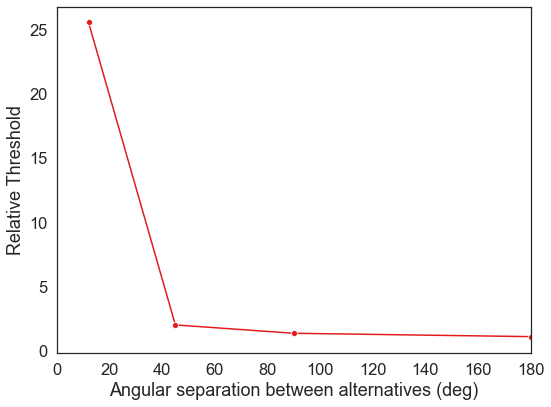

In [38]:
c4plot = [v[0] for i, v in enumerate(opt_c)]

rel_th = c4plot / min(opt_c)

sns.lineplot(thetas_2, rel_th, marker="o")
plt.xlim(0, 180)
plt.xlabel("Angular separation between alternatives (deg)")
plt.ylabel("Relative Threshold")
plt.savefig("figs/fig_3_C.png", dpi=600)
plt.show()

## Multiple Discrimination Task <a name="multiple_discrimination"></a>
The Likelihood functions used are the same as for the [Identification task](#identification)

In [39]:
# parameters
trials = 100
theta_1 = 0
theta_2 = 45
alternatives = [2, 4, 8, 16, 32]

### Figure 3 D <a name="fig_3d"></a>

In [40]:
def opt_th2(C, alternative, theta_1, theta_2, trials):
    dist_angles = 360 / alternative
    L_1 = L_(trials, theta_1, theta_i, N, C, t, R_max, R_min, kappa)
    L_2 = L_(trials, theta_2, theta_i, N, C, t, R_max, R_min, kappa)
    Ls = np.zeros(trials)
    for i in range(1, 1 + alternative):
        theta_3 = np.radians(i * dist_angles)
        l_3 = L_3(
            C,
            trials,
            L_1,
            L_2,
            theta_3,
            theta_1,
            theta_2,
            theta_i,
            N,
            t,
            R_max,
            R_min,
            kappa,
        )

        Ls = np.vstack((Ls, l_3))

    maxs = np.amax(Ls, axis=0)
    percentage = np.sum(L_1 > maxs) / trials

    err = (0.8 - percentage) ** 2
    return err

In [47]:
opt_th2(0.6, 4, theta_1, theta_2, trials)

0.10240000000000005

In [48]:
# from fig 3c
opt_c2 = []

for alternative in alternatives:
    opt_c2.append(fmin(opt_th2, x0=0.1, args=(alternative, theta_1, theta_2, trials)))

Optimization terminated successfully.
         Current function value: 0.040000
         Iterations: 38
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: 0.032400
         Iterations: 64
         Function evaluations: 168


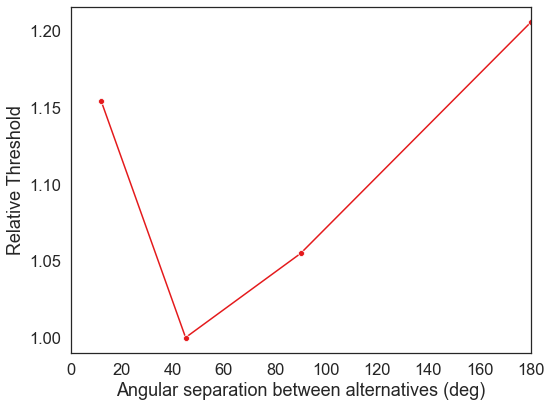

In [50]:
c4plot = [v[0] for i, v in enumerate(opt_c2)]

rel_th = c4plot / min(opt_c2)

sns.lineplot(thetas_2, rel_th, marker="o")
plt.xlim(0, 180)
plt.xlabel("Angular separation between alternatives (deg)")
plt.ylabel("Relative Threshold")
plt.savefig("figs_fig_3_C.png", dpi=600)
plt.show()

## Final Figure 3 <a name="fig3"></a>

## References <a name="references"></a>
- Jazayeri, M., & Movshon, J. A. (2006). Optimal representation of sensory information by neural populations.Nature Neuroscience,9(5), 690–696. https://doi.org/10.1038/nn1691
- https://math.stackexchange.com/questions/41608/definite-integral-of-normal-distribution